## Dog Breed Classifier- SageMaker

Training a simple CNN using SageMaker. Want to be able to run for one epoch on the Notebook instance to check that it is working. Then would like to run for one epoch on a training instance, and then for 15 epochs on a training instance. I am using SageMaker because I expect the training to take around 12 hours on my laptop, which is not really feasible. 

In [1]:
import boto3
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import tensorflow as tf

from io import BytesIO
from PIL import Image
from sagemaker import get_execution_role
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print(tf.VERSION)

1.13.1


In [2]:
role = get_execution_role()
print(role)
BUCKET = "dog-breed-classifier"
EXAMPLE_DATA_KEY = "data/example/b3beb6bab59975305146110d51fc7120.jpg"
REGION = "eu-west-1"
TRAINING_DATA_DIR = "data/training/dog_breeds"

s3_input_train = 's3://{}/{}/'.format(BUCKET, TRAINING_DATA_DIR)
print(s3_input_train)

arn:aws:iam::582147694789:role/service-role/AmazonSageMaker-ExecutionRole-20190509T213780
s3://dog-breed-classifier/data/training/dog_breeds/


Load in example image from s3 and plot it.

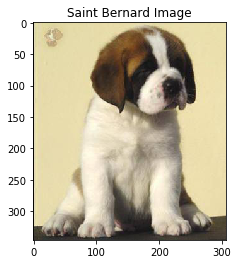

In [3]:
resource = boto3.resource("s3", region_name=REGION)
# Get s3 bucket
bucket = resource.Bucket(BUCKET)
# Get image object from s3
image_object = bucket.Object(EXAMPLE_DATA_KEY)
# Read image in
jpeg_image = BytesIO(image_object.get()['Body'].read())
image = mpimg.imread(jpeg_image, "jpeg")
plt.imshow(image)
plt.title("Saint Bernard Image")
plt.show()

## Training model on notebook instance

Print model definition code

In [4]:
! pygmentize model_def.py

import argparse
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf


if  __name__ == '__main__':
    
    print('test working')
    parser = argparse.ArgumentParser()
    
    parser.add_argument('--epochs', type=int, default=1)
    parser.add_argument('--batch_size', type=int, default=509)
    parser.add_argument('--model_dir', type=str, default=os.environ['SM_MODEL_DIR'])
    parser.add_argument('--training', type=str, default=os.environ['SM_CHANNEL_TRAINING'])
    
    args, _ = parser.parse_known_args()
    
    epochs = args.epochs
    batch_size = args.batch_size
    model_dir = args.model_dir
    train_dir = args.training
    
    
    train_data_generator = ImageDataGenerator(rescale = 1/255)

    train_generator = train_data_generator.flow_from_directory(
        train_dir,
        target_size=(300,300),
        batch_size=batch_size,
        class_mode='sparse'
    )
    
    model = tf.keras.models.Sequential([
        tf.k

In [6]:
from sagemaker.tensorflow import TensorFlow

tf_estimator = TensorFlow(entry_point = 'model_def.py',
                          role=role,
                          train_instance_count=1,
                          framework_version='1.12',
                          py_version='py3',
                          script_mode=True,
                          train_instance_type = 'local',
                          hyperparameters={'epochs' : 1}                         
                         )

In [ ]:
tf_estimator.fit({'training' : s3_input_train})

In [17]:
tf_estimator = TensorFlow(entry_point = 'model_def.py',
                          role=role,
                          train_instance_count=1,
                          train_instance_type = 'ml.m4.xlarge',
                          framework_version='1.12',
                          py_version='py3',
                          script_mode=True,
                          hyperparameters={'epochs' : 1}                         
                         )

In [19]:
tf_estimator.fit({'training' : s3_input_train})

2019-05-19 10:15:53 Starting - Starting the training job...
2019-05-19 10:15:54 Starting - Launching requested ML instances......
2019-05-19 10:16:54 Starting - Preparing the instances for training...
2019-05-19 10:17:39 Downloading - Downloading input data......
2019-05-19 10:18:53 Training - Training image download completed. Training in progress..
2019-05-19 10:18:56,588 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2019-05-19 10:18:56,594 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2019-05-19 10:18:56,887 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2019-05-19 10:18:56,905 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2019-05-19 10:18:56,919 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "training": "/opt/ml/input/data/training"
    },
    "curre

ValueError: Error for Training job sagemaker-tensorflow-scriptmode-2019-05-19-10-15-52-818: Failed Reason: AlgorithmError: ExecuteUserScriptError:
Command "/usr/bin/python model_def.py --epochs 1 --model_dir s3://sagemaker-eu-west-1-582147694789/sagemaker-tensorflow-scriptmode-2019-05-19-10-08-17-284/model"